In [56]:
import os

import math
from network import Net
import matplotlib.pyplot as plt
import numpy 

# note: if tensorflow is not install, run "pip install --upgrade tensorflow"
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import Image
import random

test_dir = "./dataset/test_set"
train_dir = "./dataset/training_set"

train_dir_cats = train_dir + "/cats"
train_dir_dogs = train_dir + "/dogs"
test_dir_cats = test_dir + "/cats"
test_dir_dogs = test_dir + "/dogs"

train_data = []
train_data_label = []
test_data = []
test_data_label = []

# Only transformed to gray pic
def normal_transform (imgpath):
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (28,28))
    return Image.fromarray(img)

# Preprocessed using gaussian_canny
def gaussian_canny_transform (imgpath):
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gaussian = cv2.GaussianBlur(img, (3,3), 0)
    gaussian = gaussian.astype(numpy.uint8)
    canny = cv2.Canny(gaussian, 50, 50)
    canny = cv2.resize(canny, (28,28))
    return Image.fromarray(canny)

# Preprocessed using sobel
def sobel_transform (imgpath):
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    height, weight = img.shape
    sobel = numpy.zeros((height, weight, 1), numpy.uint8)
    for i in range(0,height-2):
        for j in range(0,weight-2):
            gy=img[i,j]*1+img[i,j+1]*2+img[i,j+2]*1-img[i+2,j]-2*img[i+2,j+1]-img[i+2,j+2]*1
            gx=img[i,j]*1-img[i,j+2]+img[i+1,j]*2-2*img[i+1,j+2]+img[i+2,j]-img[i+2,j+2]
            grad=math.sqrt(gx*gx+gy*gy)
            if grad>50:
                sobel[i,j]=255
            else:
                sobel[i,j]=0
    print(sobel)
    # return Image.fromarray(numpy.uint8(sobel))

# Reading training data
def read_training_data(train_data, train_data_label, dir, label):
    for filename in os.listdir(dir):
        imgpath = dir + "/" + filename
        img = normal_transform(imgpath)
        train_data.append([numpy.asarray(img)])
        train_data_label.append((label))

# Reading testing data
def read_testing_data(test_data, test_data_label, dir, label):
    for filename in os.listdir(dir):
        imgpath = dir + "/" + filename
        img = normal_transform(imgpath)
        test_data.append([numpy.asarray(img)])
        test_data_label.append((label))

#read gray images into train_data and train_data_label
read_training_data(train_data, train_data_label, train_dir_cats, (0,1))
#train_data =train_data[0:250]
#train_data_label =train_data_label[0:250]
read_training_data(train_data, train_data_label, train_dir_dogs, (1,0))
#train_data =train_data[0:500]
#train_data_label =train_data_label[0:500]
for i in range(len(train_data)//2):
               tmp = train_data[i]
               train_data[i] =train_data[len(train_data)-1-i]
               train_data[len(train_data)-1-i] =tmp
               tlabel = train_data_label[i]
               train_data_label[i] = train_data_label[len(train_data)-1-i]
               train_data_label[len(train_data)-1-i] =  tlabel


#read gray images into test_data and test_data_label
read_testing_data(test_data, test_data_label, test_dir_cats, (0,1))
#test_data =test_data[0:100]
#test_data_label =test_data_label[0:100]
read_testing_data(test_data, test_data_label, test_dir_dogs, (1,0))
for i in range(len(test_data)//2):
               tmp = test_data[i]
               test_data[i] =test_data[len(test_data)-1-i]
               test_data[len(test_data)-1-i] =tmp
               tlabel = test_data_label[i]
               test_data_label[i] = test_data_label[len(test_data)-1-i]
               test_data_label[len(test_data)-1-i] =  tlabel
#test_data =test_data[0:200]
#test_data_label =test_data_label[0:200]
train_data =train_data[0:500]
train_data_label =train_data_label[0:500]
test_data =test_data[1000:1200]
test_data_label =test_data_label[1000:1200]
train_data = numpy.array(train_data)

test_data = numpy.array(test_data)

train_data_label = numpy.array(train_data_label)

test_data_label = numpy.array(test_data_label)



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784) (55000, 10)


(28, 28)


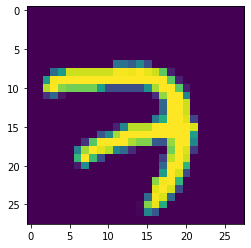

In [57]:
print(train_data.shape, train_data_label.shape)
print(test_data.shape, test_data_label.shape)

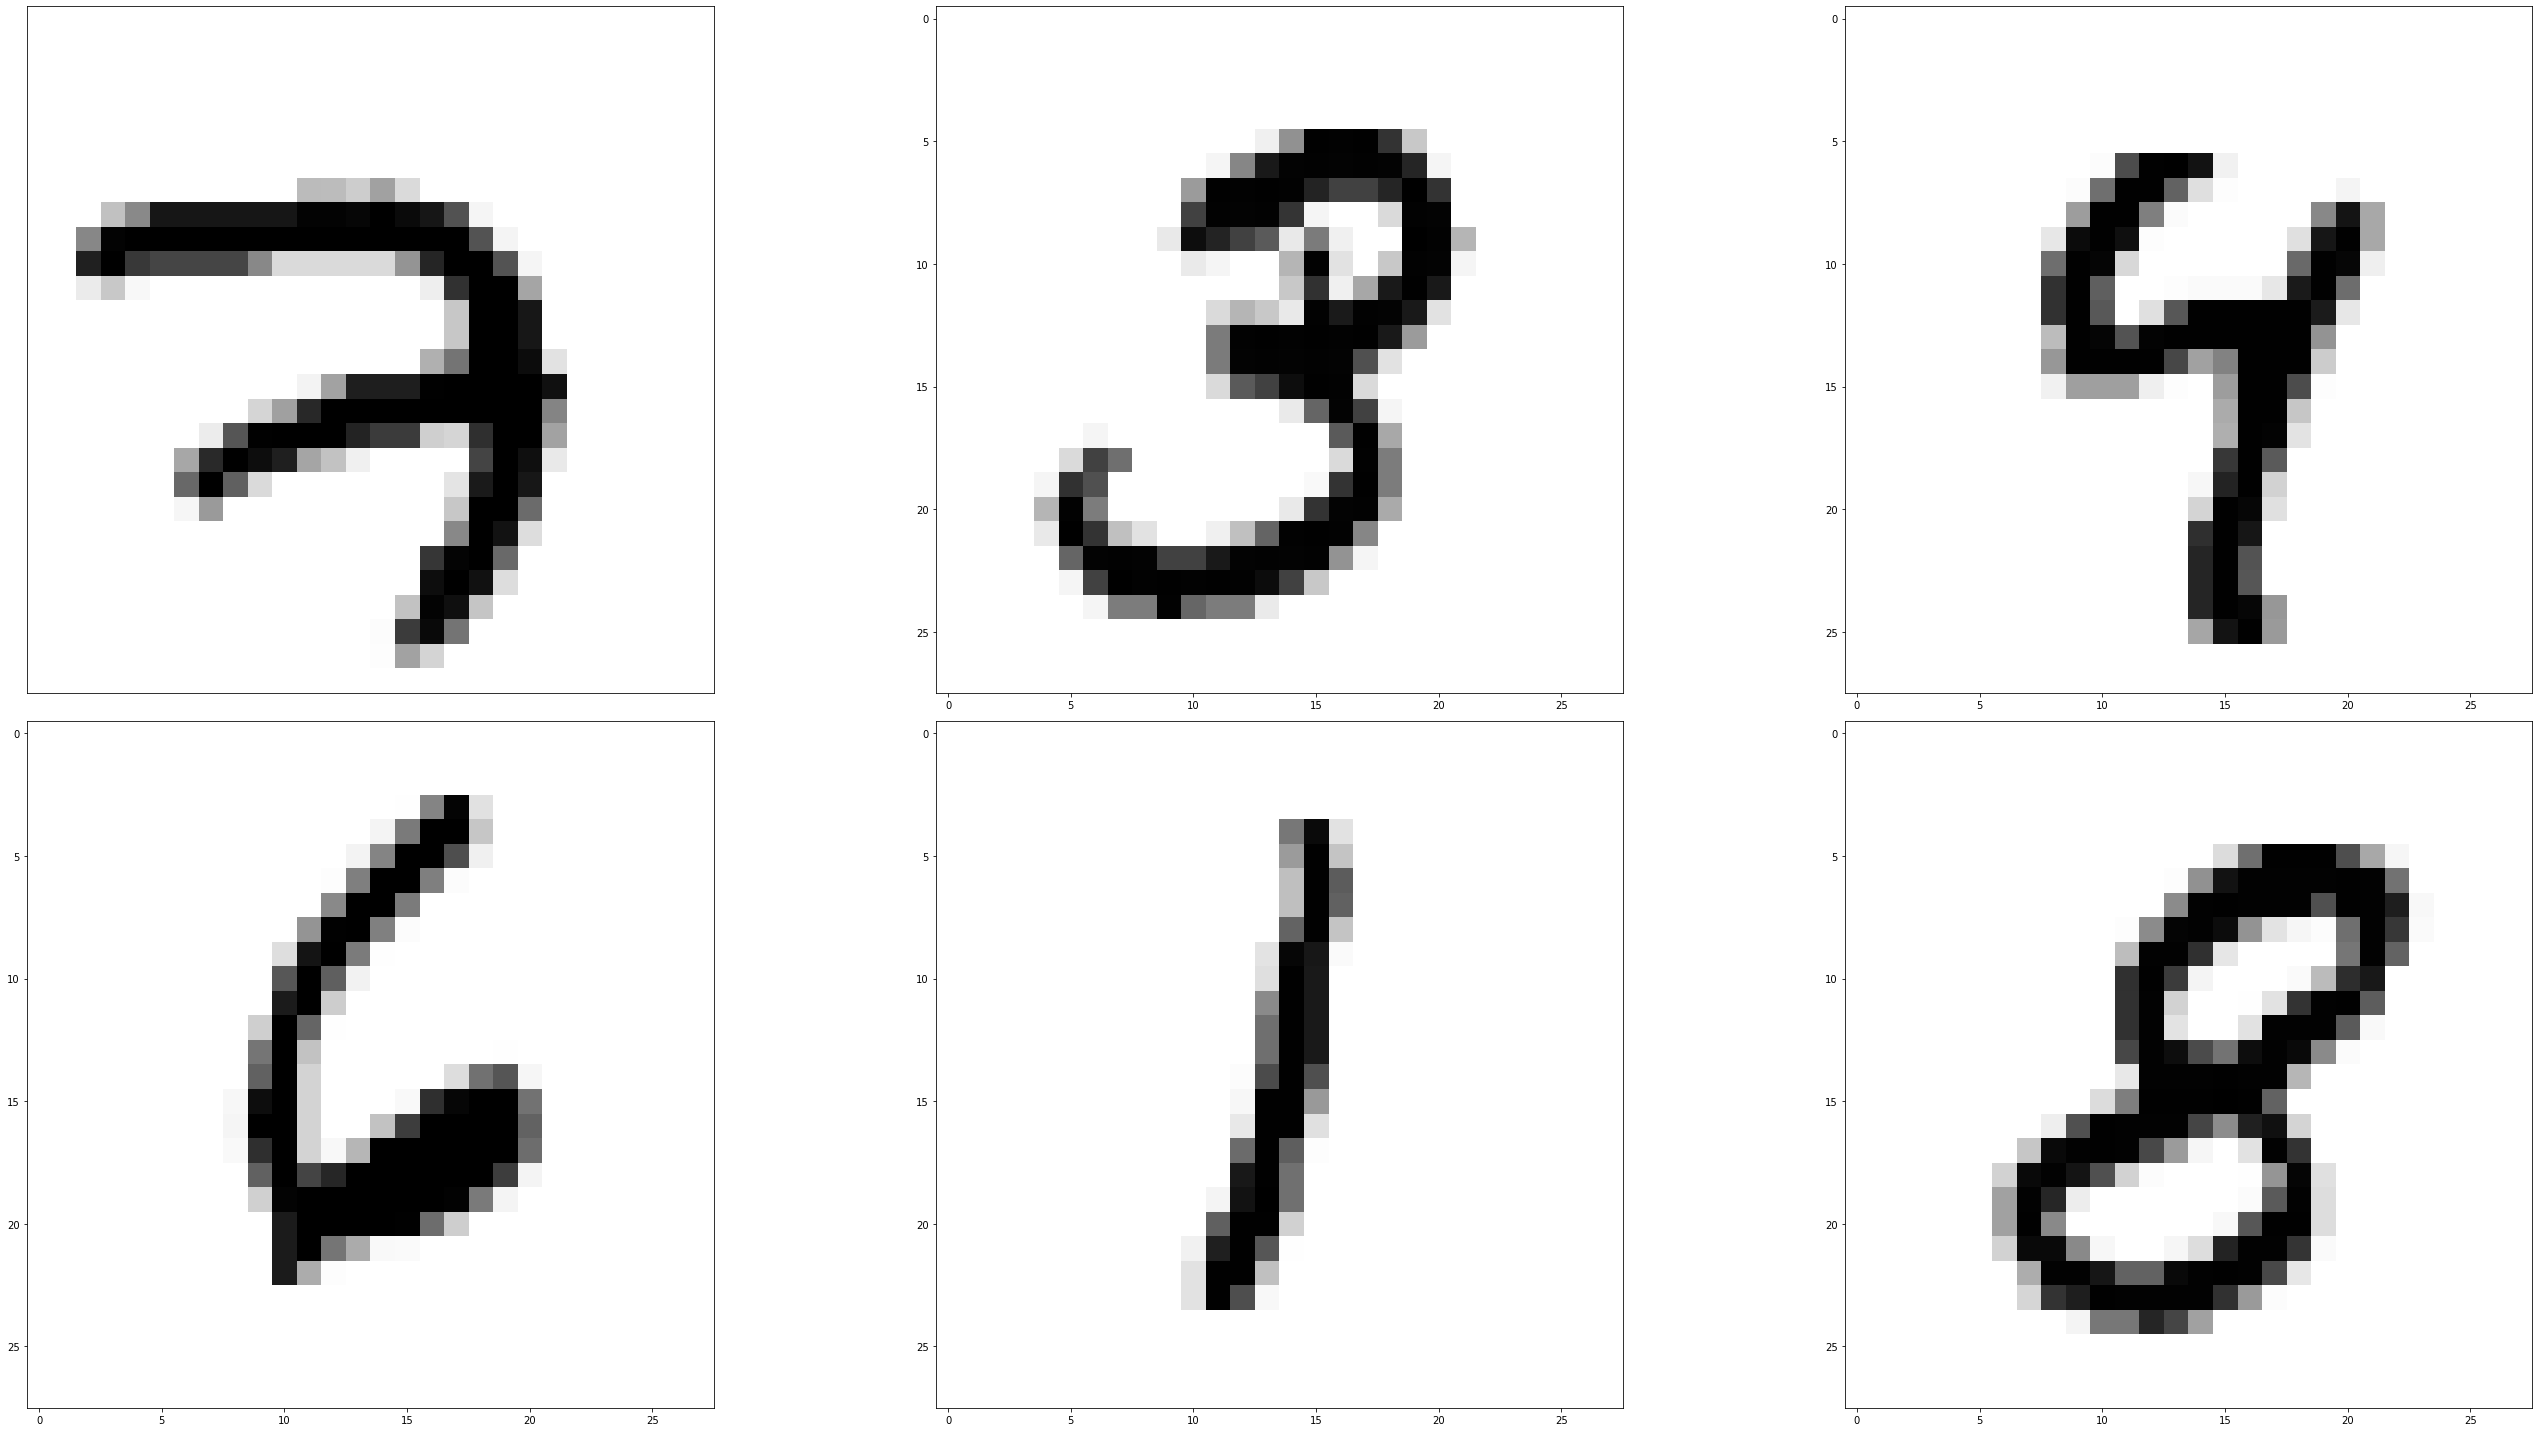

In [59]:
import numpy as np

In [60]:
class ConvLayer:
  # 卷积层，输入包含四个参数，这里默认使用valid padding，即不对输入做padding
    def __init__(self, num_filters, length, width, stride):
        """
        num_filters: 卷积核个数
        length：     卷积核长
        width：      卷积核宽
        stride：     卷积核步长
        """
        self.num_filters = num_filters
        self.length = length
        self.width = width
        self.stride = stride
        # 所有卷积参数构成一个3维矩阵， (num_filters, lenght, width)
        # 参数随机初始化，除length*width减小方差
        self.filters = np.random.randn(num_filters, length, width) / (length*width)
        
    def iterate_regions(self, image):
        """
        输入： image，单通道图片矩阵
        输出： (im_region, i, j), 所有length x width 大小的图片区域及对应位置索引
        """
        h, w = image.shape
        h_new = (h-self.length) // self.stride + 1
        w_new = (w-self.width) // self.stride + 1
        for i in range(h_new):
            for j in range(w_new):
                im_region = image[i*self.stride:(i*self.stride + self.length), j*self.stride:(j*self.stride + self.width)]
                yield im_region, i, j
                
    def forward(self, input):
        """
        输入： input， 二维矩阵
        输出：(h_new, w_new, num_filters)， 三维卷积输出
        """
        h, w = input.shape
        h_new = (h-self.length) // self.stride + 1
        w_new = (w-self.width) // self.stride + 1
        output = np.zeros((h_new, w_new, self.num_filters))
        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))
        return output

In [61]:
class MaxPoolingLayer:
  # 池化层
    def __init__(self, num_filters, length, width, stride):
        """
        num_filters: 池化核个数
        length：     池化核长
        width：      池化核宽
        stride：     池化核步长
        """
        self.num_filters = num_filters
        self.length = length
        self.width = width
        self.stride = stride
        
    def iterate_regions(self, image):
        """
        输入： image，二维矩阵
        输出： (im_region, i, j), 所有length x width 大小的矩阵区域及对应位置索引
        """
        h, w, _ = image.shape
        h_new = (h-self.length) // self.stride + 1
        w_new = (w-self.width) // self.stride + 1
        for i in range(h_new):
            for j in range(w_new):
                im_region = image[(i * self.stride):(i * self.stride + self.length), (j * self.stride):(j * self.stride + self.width)]
                yield im_region, i, j

    def forward(self, input):
        """
        input: (h, w, num_filters),3维矩阵
        output: (h / 2, w / 2, num_filters).
        """
        h, w, num_filters = input.shape
        h_new = (h-self.length) // self.stride + 1
        w_new = (w-self.width) // self.stride + 1
        output = np.zeros((h_new, w_new, num_filters))
        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.amax(im_region, axis=(0, 1))
        return output

In [62]:
class SoftmaxLayer:
  # 全连接层带softmax激活函数.
    def __init__(self, input_len, nodes):
        # 参随机数初始化
        self.weights = np.random.randn(input_len, nodes) / input_len
        self.biases = np.zeros(nodes)

    def forward(self, input):
        """
        input：input can be any array with any dimensions 
        output：一维数组，表示各类别概率
        """
        input = input.flatten()

        input_len, nodes = self.weights.shape

        totals = np.dot(input, self.weights) + self.biases
        exp = np.exp(totals)
        return exp / np.sum(exp, axis=0)

In [63]:
class SoftmaxLayer:
  # 全连接层带softmax激活函数.

    def __init__(self, input_len, nodes):
        # 参随机数初始化
        self.weights = np.random.randn(input_len, nodes) / input_len
        self.biases = np.zeros(nodes)
        
    def backprop(self, d_L_d_out, learning_rate):
        """
        input: (d_L_d_out,learning_rate), (损失对输出结果的导数,学习率)
        output: d_L_d_inputs， 损失对输入数据的导数
        """
        # d_L_d_out当中只有真实标签所在位置数值不为0
        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue

            # e^totals
            t_exp = np.exp(self.last_totals)

            # Sum of all e^totals
            S = np.sum(t_exp)

            # out[i] 对输出求导
            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

            # 输出对 weights/biases/input 的梯度
            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights

            # 损失对输出的梯度
            d_L_d_t = gradient * d_out_d_t

            # 链式法则求损失对weights/biases/input 的梯度
            d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
            d_L_d_b = d_L_d_t * d_t_d_b
            d_L_d_inputs = d_t_d_inputs @ d_L_d_t

            # 更新 weights / biases
            self.weights -= learning_rate * d_L_d_w
            self.biases -= learning_rate * d_L_d_b
        return d_L_d_inputs.reshape(self.last_input_shape)
    def forward(self, input):
        """
        input：input can be any array with any dimensions 
        output：一维数组，表示各类别概率
        """
        self.last_input_shape = input.shape
        
        input = input.flatten()
        self.last_input = input
        
        input_len, nodes = self.weights.shape

        totals = np.dot(input, self.weights) + self.biases
        
        self.last_totals = totals
        
        exp = np.exp(totals)
        return exp / np.sum(exp, axis=0)

In [64]:
class MaxPoolLayer:
  # A Max Pooling layer .
    def __init__(self, num_filters, length, width, stride):
        self.num_filters = num_filters
        self.length = length
        self.width = width
        self.stride = stride
        
    def iterate_regions(self, image):
        """
        输入： image，二维矩阵
        输出： (im_region, i, j), 所有length x width 大小的矩阵区域及对应位置索引
        """
        h, w, _ = image.shape
        h_new = (h-self.length) // self.stride + 1
        w_new = (w-self.width) // self.stride + 1
        for i in range(h_new):
            for j in range(w_new):
                im_region = image[(i * self.stride):(i * self.stride + self.length), (j * self.stride):(j * self.stride + self.width)]
                yield im_region, i, j

    def forward(self, input):
        """
        输入： image，二维矩阵
        输出： (im_region, i, j), 所有length x width 大小的矩阵区域及对应位置索引
        """
        h, w, num_filters = input.shape
        self.last_input = input
        
        h_new = (h-self.length) // self.stride + 1
        w_new = (w-self.width) // self.stride + 1
        output = np.zeros((h_new, w_new, num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.amax(im_region, axis=(0, 1))
        return output
    def backprop(self, d_L_d_out):
        """
        input: (h, w, num_filters),3维矩阵
        output: (h / 2, w / 2, num_filters).
        """
        d_L_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))

            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        # If this pixel was the max value, copy the gradient to it.
                        if im_region[i2, j2, f2] == amax[f2]:
                            d_L_d_input[i * self.length + i2, j * self.width + j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input

In [65]:
import numpy as np

class ConvLayer:
  # A Convolution layer
    def __init__(self, num_filters, length, width, stride):
        """
        num_filters: 卷积核个数
        length：     卷积核长
        width：      卷积核宽
        stride：     卷积核步长
        """
        self.num_filters = num_filters
        self.length = length
        self.width = width
        self.stride = stride

        # 所有卷积参数构成一个3维矩阵， (num_filters, lenght, width)
        # 参数随机初始化，除length*width减小方差
        self.filters = np.random.randn(num_filters, length, width) / (length*width)
    def iterate_regions(self, image):
        """
        输入： image，二维矩阵
        输出： (im_region, i, j), 所有length x width 大小的矩阵区域及对应位置索引
        """
        h, w = image.shape
        h_new = (h-self.length) // self.stride + 1
        w_new = (w-self.width) // self.stride + 1
        for i in range(h_new):
            for j in range(w_new):
                im_region = image[i*self.stride:(i*self.stride + self.length), j*self.stride:(j*self.stride + self.width)]
                yield im_region, i, j
    def backprop(self, d_L_d_out, learning_rate):
        """
        input: (d_L_d_out,learning_rate), (损失对输出结果的导数,学习率)
        output: d_L_d_inputs， 损失对输入数据的导数
        """
        d_L_d_filters = np.zeros(self.filters.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

        # 更新卷积参数
        self.filters -= learning_rate * d_L_d_filters

        return None
    def forward(self, input):
        """
        输入： input， 二维矩阵
        输出：(h_new, w_new, num_filters)， 三维卷积输出
        """
        h, w = input.shape
        self.last_input = input
        h_new = (h-self.length) // self.stride + 1
        w_new = (w-self.width) // self.stride + 1
        output = np.zeros((h_new, w_new, self.num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

        return output

In [66]:
train_images = train_X.reshape(-1,28,28)
train_labels = train_Y

In [67]:
train_images.shape

(55000, 28, 28)

In [68]:
train_labels.shape

(55000, 10)

In [69]:
train_images = train_X.reshape(-1,28,28)
train_labels = train_Y
print(train_images.shape)
conv = ConvLayer(8,3,3,1)
output = conv.forward(train_images[0])
print(output.shape) # (26, 26, 8)
pool = MaxPoolLayer(8,2,2,2)
output = pool.forward(output)
print(output.shape) # (13, 13, 8)
softmax = SoftmaxLayer(13 * 13 * 8, 10) # 13x13x8 -> 10
out = softmax.forward(output)
print(out)

(55000, 28, 28)
(26, 26, 8)
(13, 13, 8)
[0.09969568 0.1002037  0.10043689 0.09985315 0.10023377 0.09903822
 0.10010212 0.09976231 0.10026143 0.10041273]


In [70]:
pool = MaxPoolLayer(8,2,2,2)
output = pool.forward(output)
print(output.shape) # (13, 13, 8)

(6, 6, 8)


In [71]:
conv2 = ConvLayer(8,3,3,1)
output = conv2.forward(train_images[0])
print(output.shape) # (26, 26, 8)
softmax = SoftmaxLayer(13 * 13 * 8, 10) # 13x13x8 -> 10

(26, 26, 8)


In [72]:
softmax = SoftmaxLayer(13 * 13 * 8, 10) # 13x13x8 -> 10

In [73]:
out = softmax.forward(output)

ValueError: shapes (5408,) and (1352,10) not aligned: 5408 (dim 0) != 1352 (dim 0)

In [ ]:
print(out)

In [ ]:
train_labels[0]

In [ ]:
sum(out*train_labels[0])

In [ ]:
# demo使用一千张图片做训练与测试， 可以使用全部的训练和测试图片，训练时间会比较久一些
train_images = train_X.reshape(-1,28,28)[:1000]
train_labels = train_Y[:1000]

test_images = test_X.reshape(-1,28,28)[:1000]
test_labels = test_Y[:1000]

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

In [ ]:
conv = ConvLayer(8,3,3,1)                  # 28x28x1 -> 26x26x8
pool = MaxPoolingLayer(8,2,2,2)                  # 26x26x8 -> 13x13x8
softmax = SoftmaxLayer(13 * 13 * 8, 10) # 13x13x8 -> 10

In [ ]:
def forward(image, label):
    """
    CNN 前向传播并计算 accuracy 与 cross-entropy loss.
    - image： 2d numpy array
    - label： one-hot encoded digit
    """
    
    # 将图片像素值从 [0, 255] 转换到 [-0.5, 0.5] ，这样更便于网络进行训练
    out = conv.forward((image / 255.0) - 0.5)
    out = pool.forward(out)
    out = softmax.forward(out)

    # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
    digit = np.argmax(label)
    loss = -np.log(out[digit])
    acc = 1 if np.argmax(out) == digit else 0
    return out, loss, acc

In [ ]:
forward(train_images[0], train_labels[0])

In [ ]:
def train(im, label, lr=0.01):
    """
    前向传播->后向传播->更新梯度->计算损失及准确率
    image: 2d numpy array
    label: one-hot encoded digit
    lr: learning rate
    """
    # Forward
    out, loss, acc = forward(im, label)

    # Calculate initial gradient
    digit = np.argmax(label)
    gradient = np.zeros(10)
    gradient[digit] = -1 / out[digit]

    # Backprop
    gradient = softmax.backprop(gradient, lr)
    gradient = pool.backprop(gradient)
    gradient = conv.backprop(gradient, lr)

    return loss, acc

In [ ]:
train(train_images[0], train_labels[0])

In [ ]:
# Train the CNN for 3 epochs
for epoch in range(3):
    print('--- Epoch %d ---' % (epoch + 1))
    # Shuffle the training data
    permutation = np.random.permutation(len(train_images))
    train_images = train_images[permutation]
    train_labels = train_labels[permutation]
    # Train!
    loss = 0
    num_correct = 0
    for i, (image, label) in enumerate(zip(train_images, train_labels)):
        if i > 0 and i % 100 == 99:
            print('[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %(i + 1, loss / 100, num_correct))
            loss = 0
            num_correct = 0
        out = conv.forward((image / 255.0) - 0.5)
        out = pool.forward(out)
        out = softmax.forward(out)
        # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
        digit = np.argmax(label)
        loss = -np.log(out[digit])
        acc = 1 if np.argmax(out) == digit else 0
            # Calculate initial gradient
        gradient = np.zeros(10)
        gradient[digit] = -1 / out[digit]
        # Backprop
        lr = 0.01
        gradient = softmax.backprop(gradient, lr)
        gradient = pool.backprop(gradient)
        gradient = conv.backprop(gradient, lr)
        loss += l
        num_correct += acc

In [ ]:
# demo使用一千张图片做训练与测试， 可以使用全部的训练和测试图片，训练时间会比较久一些
train_images = train_X.reshape(-1,28,28)[:1000]
train_labels = train_Y[:1000]

test_images = test_X.reshape(-1,28,28)[:1000]
test_labels = test_Y[:1000]

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

conv = ConvLayer(8,3,3,1)                  # 28x28x1 -> 26x26x8
pool = MaxPoolingLayer(8,2,2,2)                  # 26x26x8 -> 13x13x8
softmax = SoftmaxLayer(13 * 13 * 8, 10) # 13x13x8 -> 10

def forward(image, label):
    """
    CNN 前向传播并计算 accuracy 与 cross-entropy loss.
    - image： 2d numpy array
    - label： one-hot encoded digit
    """
    
    # 将图片像素值从 [0, 255] 转换到 [-0.5, 0.5] ，这样更便于网络进行训练
    out = conv.forward((image / 255) - 0.5)
    out = pool.forward(out)
    out = softmax.forward(out)

    # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
    digit = np.argmax(label)
    loss = -np.log(out[digit])
    acc = 1 if np.argmax(out) == digit else 0
    return out, loss, acc

def train(im, label, lr=0.005):
    """
    前向传播->后向传播->更新梯度->计算损失及准确率
    image: 2d numpy array
    label: one-hot encoded digit
    lr: learning rate
    """
    # Forward
    out, loss, acc = forward(im, label)

    # Calculate initial gradient
    digit = np.argmax(label)
    gradient = np.zeros(10)
    gradient[digit] = -1 / out[digit]

    # Backprop
    gradient = softmax.backprop(gradient, lr)
    gradient = pool.backprop(gradient)
    gradient = conv.backprop(gradient, lr)

    return loss, acc

print('MNIST CNN initialized!')

# Train the CNN for 3 epochs
for epoch in range(3):
    print('--- Epoch %d ---' % (epoch + 1))

    # Shuffle the training data
    permutation = np.random.permutation(len(train_images))
    train_images = train_images[permutation]
    train_labels = train_labels[permutation]

    # Train!
    loss = 0
    num_correct = 0
    for i, (im, label) in enumerate(zip(train_images, train_labels)):
        if i > 0 and i % 100 == 99:
            print('[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %(i + 1, loss / 100, num_correct))
            loss = 0
            num_correct = 0

        l, acc = train(im, label)
        loss += l
        num_correct += acc

# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
    _, l, acc = forward(im, label)
    loss += l
    num_correct += acc

num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)

In [ ]:
import numpy as np
import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import to_categorical
from keras.optimizers import SGD

train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

model = Sequential([
  Conv2D(8, 3, input_shape=(28, 28, 1), use_bias=False),
  MaxPooling2D(pool_size=2),
  Flatten(),
  Dense(10, activation='softmax'),
])

model.compile(SGD(lr=.005), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
  train_images,
  to_categorical(train_labels),
  batch_size=1,
  epochs=3,
  validation_data=(test_images, to_categorical(test_labels)),
)